<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com). Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_tutorial/).</i></small>

# Density Estimation: Gaussian Mixture Models

Here we'll explore **Gaussian Mixture Models**, which is an unsupervised clustering & density estimation technique.

We'll start with our standard set of initial imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn')

## Introducing Gaussian Mixture Models

We previously saw an example of K-Means, which is a clustering algorithm which is most often fit using an expectation-maximization approach.

Here we'll consider an extension to this which is suitable for both **clustering** and **density estimation**.

For example, imagine we have some one-dimensional data in a particular distribution:

C:\Users\Owner\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


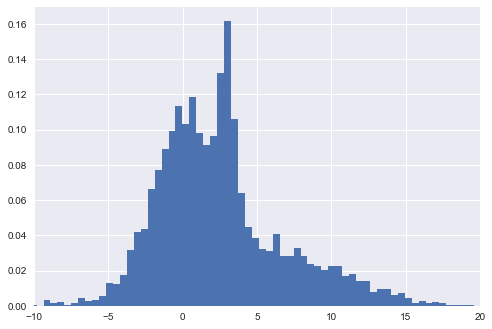

In [4]:
np.random.seed(2)
x = np.concatenate([np.random.normal(0, 2, 2000),
                    np.random.normal(5, 5, 2000),
                    np.random.normal(3, 0.5, 600)])
plt.hist(x, 80, normed=True)
plt.xlim(-10, 20);

Gaussian mixture models will allow us to approximate this density:

In [5]:
from sklearn.mixture import GaussianMixture as GMM
X = x[:, np.newaxis]
clf = GMM(4, max_iter=500, random_state=3).fit(X)

In [6]:
xpdf = np.linspace(-10, 20, 1000)
density = np.array([np.exp(clf.score([[xp]])) for xp in xpdf]) # clf.score([[x]]) >> log-likelihood 

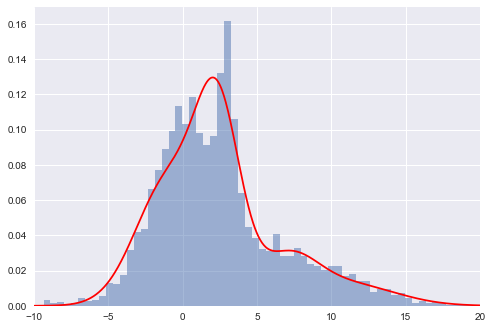

In [25]:
plt.hist(x, 80, density=True, alpha=0.5)
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

# it does a similar job to the Kernel Density Estimation (see below)

Note that this density is fit using a **mixture of Gaussians**, which we can examine by looking at the ``means_``, ``covars_``, and ``weights_`` attributes:

In [8]:
clf.means_

array([[ 2.39320358],
       [11.10146615],
       [-0.92594954],
       [ 7.038217  ]])

In [9]:
clf.covariances_

array([[[ 2.25389935]],

       [[10.09336755]],

       [[ 4.98190633]],

       [[ 3.8837469 ]]])

In [10]:
clf.weights_

array([0.38379114, 0.09799968, 0.39491057, 0.1232986 ])

C:\Users\Owner\anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


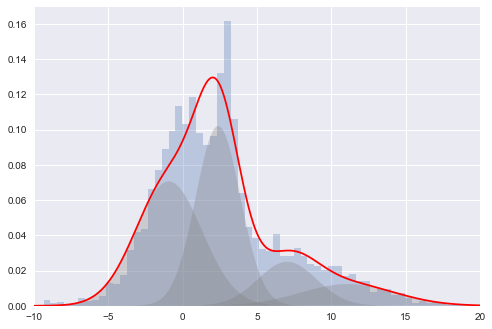

In [11]:
plt.hist(x, 80, normed=True, alpha=0.3)
plt.plot(xpdf, density, '-r')

for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covariances_[i, 0])).pdf(xpdf)
    plt.fill(xpdf, pdf, facecolor='gray',
             edgecolor='none', alpha=0.3)
plt.xlim(-10, 20);

These individual Gaussian distributions are fit using an expectation-maximization method, much as in K means, except that rather than explicit cluster assignment, the **posterior probability** is used to compute the weighted mean and covariance.
Somewhat surprisingly, this algorithm **provably** converges to the optimum (though the optimum is not necessarily global).

## How many Gaussians?

Given a model, we can use one of several means to evaluate how well it fits the data.
For example, there is the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC)

In [43]:
print(clf.bic(X))
print(clf.aic(X))
# the lower the value, the better?

25936.910993750924
25866.139066343676


$$AIC = 2k-2ln(L)$$

* $k$: the number of parameters    
* $L$: the maximum likelihood

Given a set of candidate models for the data, the preferred model is the one with the minimum AIC value. Thus, AIC rewards goodness of fit (as assessed by the likelihood function), but it also includes a penalty that is an increasing function of the number of estimated parameters. The penalty discourages overfitting, which is desired because increasing the number of parameters in the model almost always improves the goodness of the fit.

Let's take a look at these as a function of the number of gaussians:

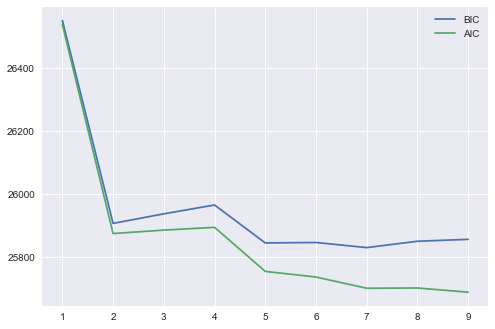

In [42]:
n_estimators = np.arange(1, 10)
clfs = [GMM(n, max_iter=1000).fit(X) for n in n_estimators]
bics = [clf.bic(X) for clf in clfs]
aics = [clf.aic(X) for clf in clfs]

plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')
plt.legend();

It appears that for both the AIC and BIC, 4 components is preferred. (5 seems better though?)

## Example: GMM For Outlier Detection

GMM is what's known as a **Generative Model**: it's a probabilistic model from which a dataset can be generated.
One thing that generative models can be useful for is **outlier detection**: we can simply evaluate the likelihood of each point under the generative model; the points with a suitably low likelihood (where "suitable" is up to your own bias/variance preference) can be labeld outliers.

Let's take a look at this by defining a new dataset with some outliers:

In [18]:
np.random.seed(0)

# Add 20 outliers
true_outliers = np.sort(np.random.randint(0, len(x), 20)) # index 
y = x.copy()
y[true_outliers] += 50 * np.random.randn(20) # turn the selected index into outliers 

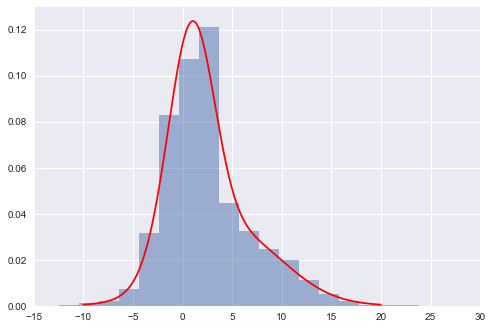

In [40]:
clf = GMM(4, max_iter=500, random_state=0).fit(y[:, np.newaxis])
xpdf = np.linspace(-10, 20, 1000)
density_noise = np.array([np.exp(clf.score([[xp]])) for xp in xpdf]) # clf.score() returns a log-likelihood

plt.hist(y, 80, density=True, alpha=0.5)
plt.plot(xpdf, density_noise, '-r')
plt.xlim(-15, 30);

In [38]:
print(clf.score([[xpdf[0]]])) # this returns the average log-likelihood of the list but here we only have one element
print(clf.score_samples([[xpdf[0]]])) # this returns a list of log-likelihoods (for all the elements)

-7.583128881363917
[-7.58312888]


Now let's evaluate the log-likelihood of each point under the model, and plot these as a function of ``y``:

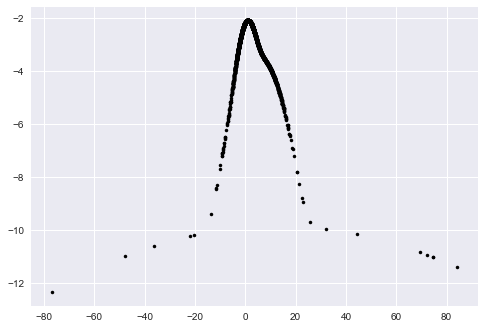

In [20]:
log_likelihood = np.array([clf.score_samples([[yy]]) for yy in y])
# log_likelihood = clf.score_samples(y[:, np.newaxis])[0]
plt.plot(y, log_likelihood, '.k');

In [21]:
detected_outliers = np.where(log_likelihood < -9)[0]

print("true outliers:")
print(true_outliers)
print("\ndetected outliers:")
print(detected_outliers)

true outliers:
[  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607
 2732 2893 2897 3264 3468 4373]

detected outliers:
[  99  537  705 1653 2046 2135 2163 2496 2732 2893 2897 3067 3468 4373]


The algorithm misses a few of these points, which is to be expected (some of the "outliers" actually land in the middle of the distribution!)

Here are the outliers that were missed:

In [22]:
set(true_outliers) - set(detected_outliers)

{1033, 1701, 1871, 2222, 2599, 2607, 3264}

And here are the non-outliers which were spuriously labeled outliers:

In [23]:
set(detected_outliers) - set(true_outliers)

{3067}

Finally, we should note that although all of the above is done in one dimension, GMM does generalize to multiple dimensions, as we'll see in the breakout session.

## Other Density Estimators

The other main density estimator that you might find useful is *Kernel Density Estimation*, which is available via ``sklearn.neighbors.KernelDensity``. In some ways, this can be thought of as a generalization of GMM where there is a gaussian placed at the location of **every** training point!

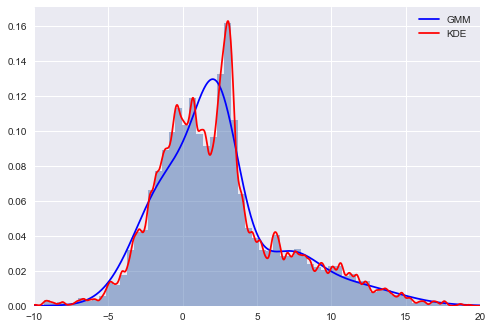

In [26]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(0.15).fit(x[:, None])
density_kde = np.exp(kde.score_samples(xpdf[:, None]))

plt.hist(x, 80, density=True, alpha=0.5)
plt.plot(xpdf, density, '-b', label='GMM')
plt.plot(xpdf, density_kde, '-r', label='KDE')
plt.xlim(-10, 20)
plt.legend();

All of these density estimators can be viewed as **Generative models** of the data: that is, that is, the model tells us how more data can be created which fits the model.